In [306]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine , text
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler , LabelEncoder , PolynomialFeatures
from sklearn.model_selection import train_test_split , GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error , r2_score , mean_absolute_percentage_error , mean_absolute_error
from imblearn.over_sampling import SMOTE



In [307]:
##Read data
data=pd.read_csv('cleaning_data_7.csv')
data_vis=data.copy()
pd.set_option('display.max_columns' , None) ### option to display all columns in output 

In [308]:
### Droping no need columns
columns_to_drop=['URL' , 'Title' , 'Secteur']
data_vis=data_vis.drop(columns_to_drop , axis=1)

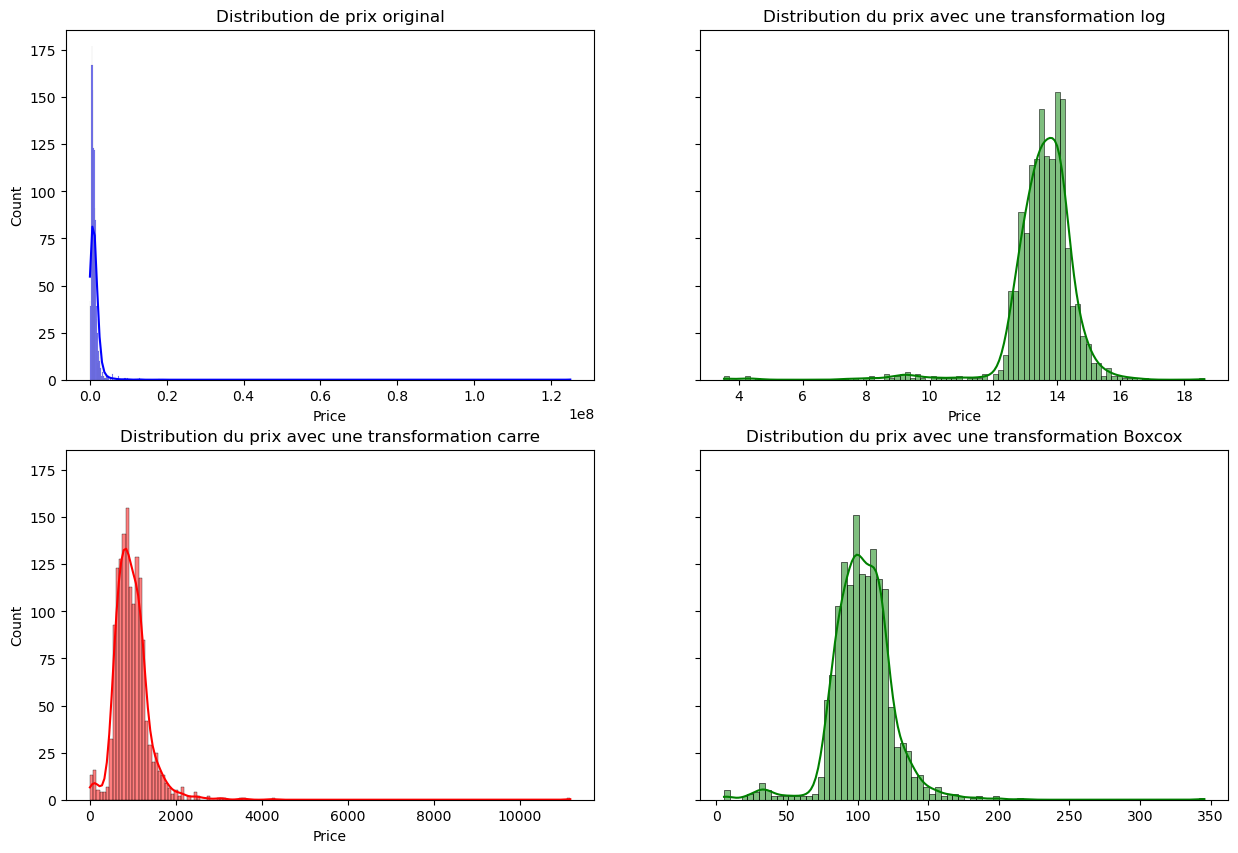

In [309]:
### visualisation : la distribution de prix 

original = data_vis['Price'] ### data original

Price_log = np.log1p(data_vis['Price'])  ###Transformation logarithme

Price_carre=np.sqrt(data_vis['Price'])  ### Transormation carre

Price_boxcox , lambda_value=boxcox(data_vis['Price']) ### Transformation boxcox


fig , axes = plt.subplots(2,2,figsize=(15,10) , sharey=True)
sns.histplot(original , kde=True , ax=axes[0 , 0] , color='blue')
axes[0 , 0].set_title('Distribution de prix original')

sns.histplot(Price_log, kde=True , ax=axes[0,1] , color='green')
axes[0,1].set_title('Distribution du prix avec une transformation log')

sns.histplot(Price_carre, kde=True , ax=axes[1,0] , color='red')
axes[1,0].set_title('Distribution du prix avec une transformation carre')

sns.histplot(Price_boxcox, kde=True , ax=axes[1 , 1] , color='green')
axes[1,1].set_title('Distribution du prix avec une transformation Boxcox')

plt.show() 

In [310]:
### replce some abberante value in rooms columns
data_vis['Chambre']=data_vis['Chambre'].str.replace('10+' , '10')
data_vis['Chambre']=pd.to_numeric(data_vis['Chambre'] , errors='coerce')

### replce some abberante value in Etage columns
data_vis['Etage']=data_vis['Etage'].str.replace('7+' , '7')
data_vis['Etage']=pd.to_numeric(data_vis['Etage'] , errors='coerce')

In [311]:
### apply boxcox transformation in price for symetric distribution
data_vis['Price_boxcox'] , lambda_value =boxcox(data_vis['Price'])
print(' la valeur de transformation est : ' , lambda_value)

 la valeur de transformation est :  0.23693740119545567


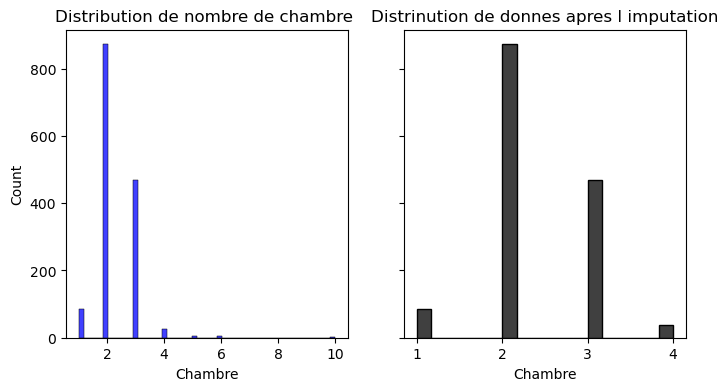

In [312]:
#### visualisaation - Rooms column 
chambre_before= data_vis['Chambre']

data_vis['Chambre']=data_vis['Chambre'].replace(6,4).replace(5,4).replace(10 , 4)

fig , axes = plt.subplots(1,2 , figsize=(8,4) ,sharey=True)

sns.histplot(chambre_before  , ax = axes[0]  , color='blue')
axes[0].set_title('Distribution de nombre de chambre ')

sns.histplot(data_vis['Chambre'] , ax=axes[1] , color='black')
axes[1].set_title('Distrinution de donnes apres l imputation')

plt.ylabel('Count')
plt.show()

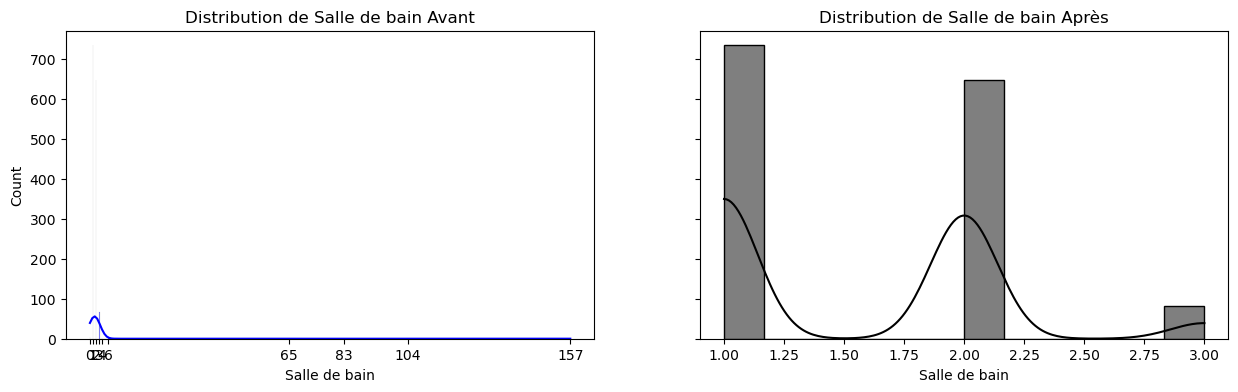

In [313]:
#### visualisaation - bathrooms column 

salle_bain_before = data_vis['Salle de bain']

data_vis['Salle de bain'] = np.where(
    data_vis['Salle de bain'].isin([6, 0, 83, 65, 157, 104, 4]),
    3,
    data_vis['Salle de bain']
)

fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

sns.histplot(salle_bain_before, ax=axes[0], color='blue' , kde=True)
axes[0].set_title('Distribution de Salle de bain Avant')
axes[0].set_xticks(sorted(salle_bain_before.unique()))  


sns.histplot(data_vis['Salle de bain'], ax=axes[1], color='black' , kde=True)
axes[1].set_title("Distribution de Salle de bain Après")

plt.ylabel('Count')
plt.show()


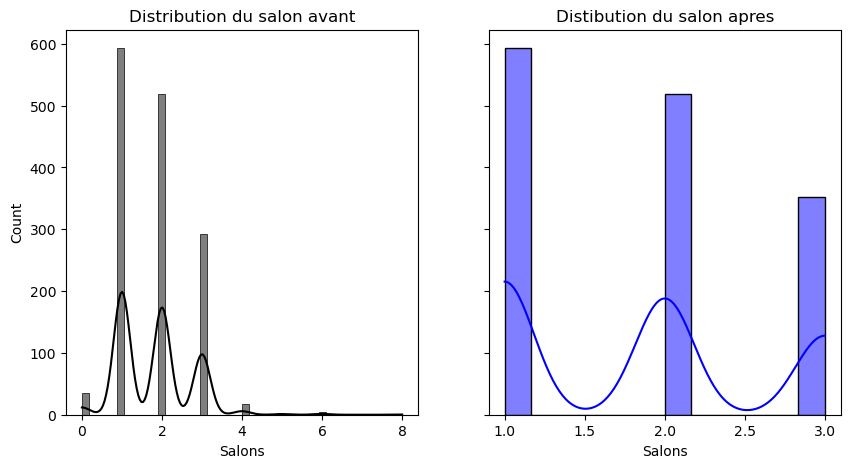

In [314]:
#### visualisaation - Salons column 

salon_before=data_vis['Salons']
data_vis['Salons']=np.where(data_vis['Salons'].isin([0.0 ,4.0 ,6.0 , 5.0 , 8.0])  , 3.0 , data_vis['Salons'])

fig , axes= plt.subplots(1 , 2 , figsize=(10,5) , sharey=True)

sns.histplot(salon_before , ax=axes[0] , kde=True , color='black')
axes[0].set_title('Distribution du salon avant')

sns.histplot(data_vis['Salons'] , ax=axes[1] , kde=True , color='blue')
axes[1].set_title('Distibution du salon apres')

plt.ylabel('Count')
plt.show()

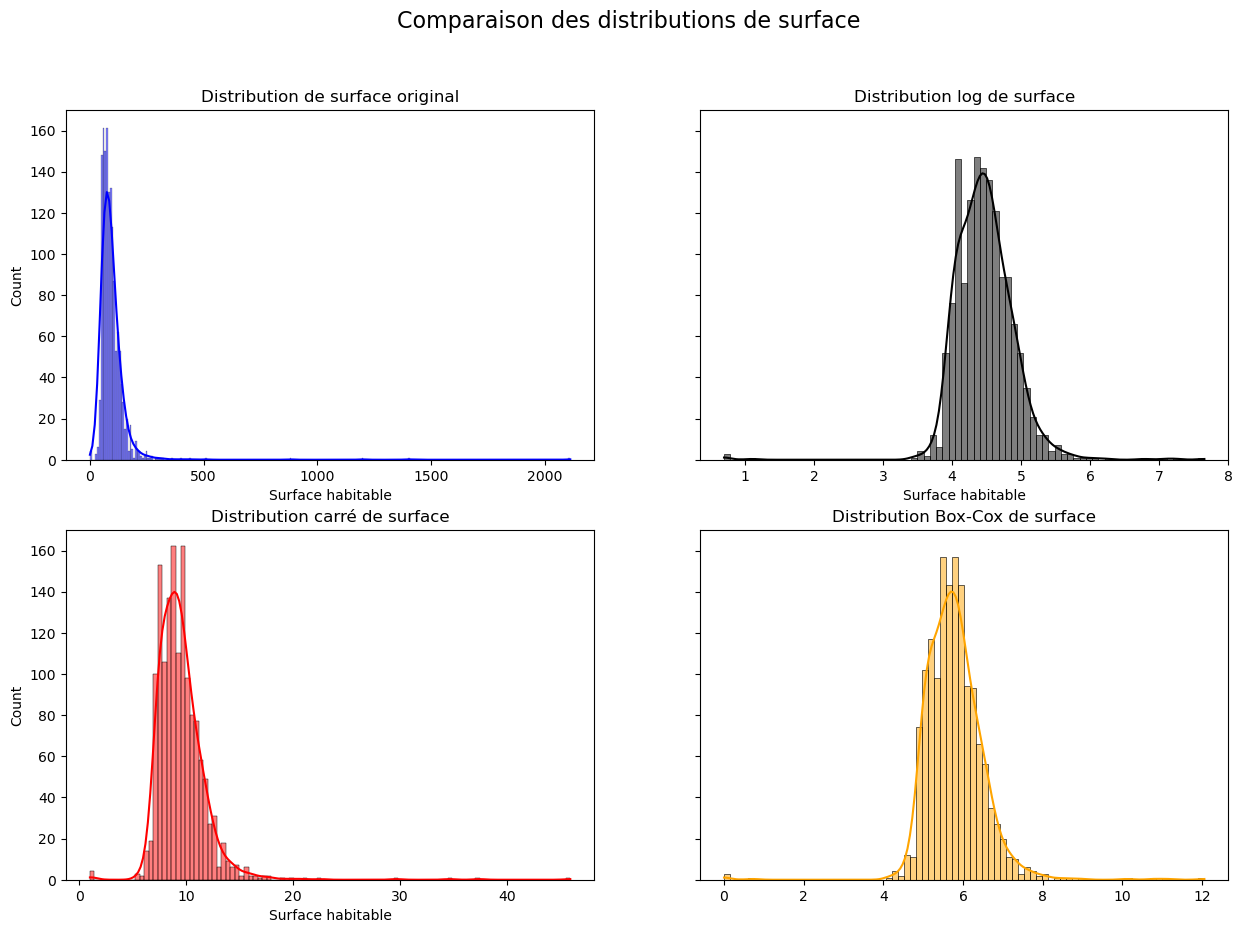

In [315]:
### Visualtion distribution of areas
surf_avant = data_vis['Surface habitable']


surf_log = np.log1p(data_vis['Surface habitable'])  # Transformation log
surf_carre = np.sqrt(data_vis['Surface habitable'])  # Transformation carré
surf_boxcox, _ = boxcox(data_vis['Surface habitable'])  # Transformation Box-Cox

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)

sns.histplot(surf_avant, ax=axes[0, 0], color='blue', kde=True)
axes[0, 0].set_title('Distribution de surface original')


sns.histplot(surf_log, ax=axes[0, 1], color='black', kde=True)
axes[0, 1].set_title('Distribution log de surface')


sns.histplot(surf_carre, ax=axes[1, 0], color='red', kde=True)
axes[1, 0].set_title('Distribution carré de surface')

sns.histplot(surf_boxcox, ax=axes[1, 1], color='orange', kde=True)
axes[1, 1].set_title('Distribution Box-Cox de surface')

fig.suptitle('Comparaison des distributions de surface', fontsize=16)

plt.show()


In [316]:
### apply boxcox transformation in area
data_vis['Surface_boxcox'] , lambda_value=boxcox(data_vis['Surface habitable'])

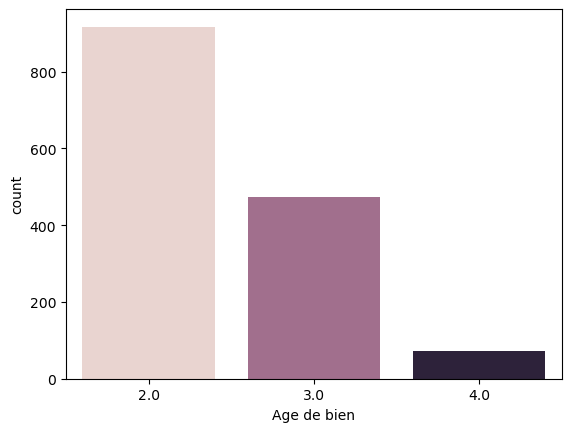

In [317]:

### PReproccing properity column
data_vis['Age de bien']=data_vis['Age de bien'].replace(0.0 , 2.0).replace(1.0 , 3.0)

data_vis['Age de bien'] = np.where(data_vis['Age de bien'].isin([8.0, 15.0, 5.0, 6.0, 25.0]), 4.0, data_vis['Age de bien'])


sns.countplot(x=data_vis['Age de bien'], hue = data_vis['Age de bien'], legend=False)

plt.ylabel('count')
plt.show()


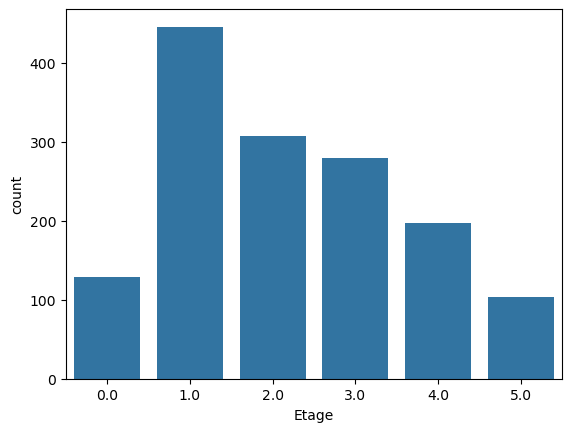

In [318]:
### equilibre etage data 
data_vis['Etage']=np.where(data_vis['Etage'].isin([8.0 , 7.0 , 6.0]) , 5 , data_vis['Etage'])
sns.countplot(x=data_vis['Etage'],legend=False)

plt.ylabel('count')
plt.show()

In [319]:
### most importants columns for training the models
data_model = data_vis[['Price_boxcox','Localisation','Chambre' , 'Salle de bain' ,'Salons' , 'Surface_boxcox' , 'Age de bien' , 'Etage' , 'Ascenseur']]


In [320]:
### change ascensuer value to boolean for the model 
boolean = {True: 1, False: 0}
data_model['Ascenseur'] = data_model['Ascenseur'].map(boolean)

/tmp/ipykernel_4765/2863232149.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['Ascenseur'] = data_model['Ascenseur'].map(boolean)


In [321]:
### Encoding Localisation Column from categorical to int 
encoder=LabelEncoder()
data_model['Loc_encoded']=encoder.fit_transform(data_model['Localisation'])
data_model=data_model.drop(['Localisation'] , axis=1)

/tmp/ipykernel_4765/902641428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['Loc_encoded']=encoder.fit_transform(data_model['Localisation'])


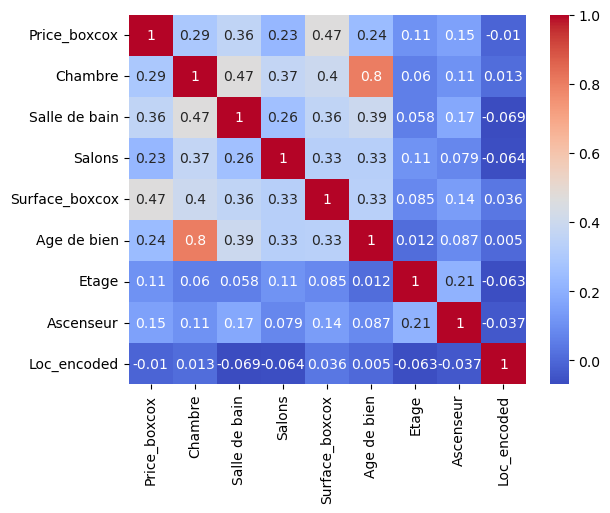

In [322]:
### visualisation des relation entre price et nombre de chambre 
cor_matrix=data_model.corr()
sns.heatmap(cor_matrix , annot=True , cmap='coolwarm')
plt.show()

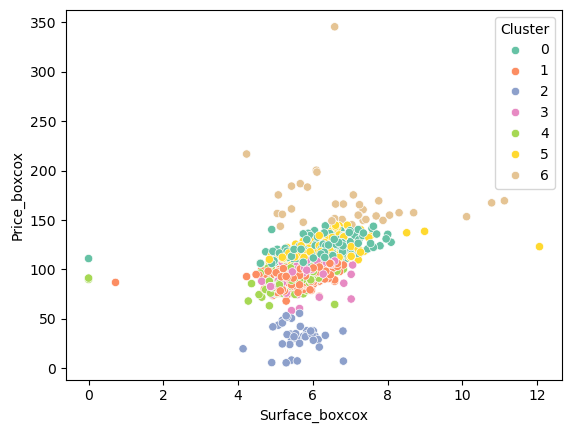

In [323]:
### identification des relations par cluster 
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=7 , random_state=42)
data_model['Cluster']=kmeans.fit_predict(data_model)
sns.scatterplot(x='Surface_boxcox' , y='Price_boxcox' , hue='Cluster' , data=data_model , palette='Set2')
plt.show()

Cluster           0.877328
Surface_boxcox    0.516038
Loc_encoded       0.270536
Salle de bain     0.149165
Chambre           0.141985
Age de bien       0.119830
Salons            0.117707
Etage             0.086445
Ascenseur         0.065826
dtype: float64


Text(0.5, 1.0, 'inforamtion regression de chaque variable sur le prix')

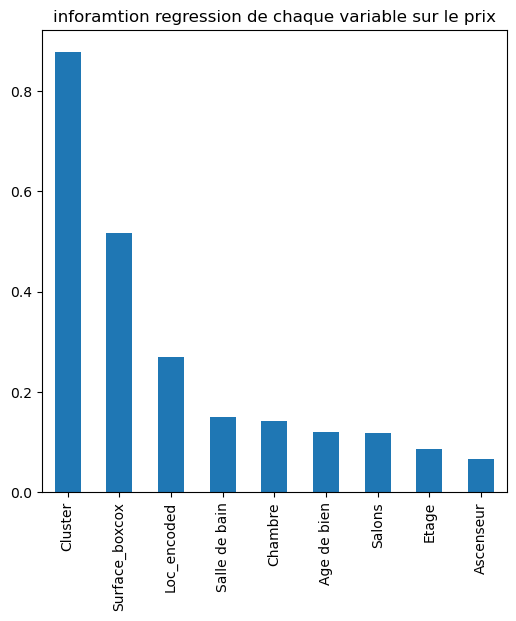

In [324]:
### identification of feature impact on price 
mi_score =mutual_info_regression(data_model.drop(columns=['Price_boxcox']) , data_model['Price_boxcox'])
mi_score =pd.Series(mi_score , index=data_model.columns.drop('Price_boxcox'))
mi_score=mi_score.sort_values(ascending=False)
print(mi_score)
mi_score.plot(kind='bar' , figsize=(6,6))
plt.title('inforamtion regression de chaque variable sur le prix')

In [325]:
### SCaling data -- using minmaxscaler to obi=tien data value in [0,1]
scaler=MinMaxScaler()
data_model['Surf_scale']=scaler.fit_transform(data_model[['Surface_boxcox']])
data_model['Price_boxcox_scale']=scaler.fit_transform(data_model[['Price_boxcox']])

In [326]:
data_model=data_model.drop(columns=['Surface_boxcox'] , axis=1)

In [327]:
### Detection anomalies bathrooms  using IQR

# Calcul des quartiles
Q1 = data_model['Salle de bain'].quantile(0.25)
Q3 = data_model['Salle de bain'].quantile(0.75)

# Calcul de l'IQR
IQR = Q3 - Q1

# Définir les bornes pour détecter les anomalies
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Sélectionner les anomalies
anomalies = data_model[(data_model['Salle de bain'] < lower_bound) | (data_model['Salle de bain'] > upper_bound)].reset_index(drop=True)

print('le nombre d\anomalies est  : ' ,  len(anomalies))
# Suppression des anomalies

# Afficher les premières lignes du DataFrame après suppression des anomalies


le nombre dnomalies est  :  0


In [328]:
### Detection anomalies area  using IQR

# Calcul des quartiles
Q1 = data_model['Surf_scale'].quantile(0.25)
Q3 = data_model['Surf_scale'].quantile(0.75)

# Calcul de l'IQR
IQR = Q3 - Q1

# Définir les bornes pour détecter les anomalies
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Sélectionner les anomalies
anomalies = data_model[(data_model['Surf_scale'] < lower_bound) | (data_model['Surf_scale'] > upper_bound)].reset_index(drop=True)

print( "le nomnre d'anomalies est " ,  len(anomalies))
# Suppression des anomalies

# Afficher les premières lignes du DataFrame après suppression des anomalies


le nomnre d'anomalies est  9


In [345]:
data_model

,Price_boxcox,Chambre,Salle de bain,Salons,Age de bien,Etage,Ascenseur,Loc_encoded,Cluster,Surf_scale,Price_boxcox_scale
0,112.125564,1,1,3.0,2.0,5.0,1,49,5,0.474490,0.313640
1,123.005393,3,2,3.0,3.0,2.0,0,49,5,0.483880,0.345626
2,94.504335,2,1,1.0,2.0,3.0,0,2,4,0.429717,0.261834
3,115.418189,2,2,1.0,2.0,1.0,0,21,0,0.469570,0.323320
4,100.499408,2,1,1.0,2.0,3.0,1,36,1,0.469570,0.279459
...,...,...,...,...,...,...,...,...,...,...,...
1458,115.418189,3,2,1.0,4.0,1.0,0,27,0,0.515365,0.323320
1459,111.512759,3,2,1.0,3.0,1.0,0,21,0,0.498357,0.311838
1460,117.461073,3,2,2.0,3.0,1.0,1,34,5,0.603088,0.329326
1461,107.206565,2,2,2.0,2.0,5.0,0,19,0,0.476096,0.299178


In [346]:
### Modele de Regression Polynomial 

### caracteristics columns for training model
X_data=data_model[['Chambre' , 'Salle de bain'  ,'Surf_scale' , 'Salons' , 'Age de bien', 'Etage' , 'Ascenseur' , 'Cluster']]

### target columns
y_data=data_model['Price_boxcox_scale']

###Spliting data in to train and test 
x_train, x_test , y_train , y_test = train_test_split(X_data , y_data , test_size=0.3 , random_state=42)

In [347]:
###Trying polynomail regresion on defferentes degree for more accuracy 
for i in range(0,5) : 
    poly = PolynomialFeatures(degree=i)

    x_train_poly=poly.fit_transform(x_train)
    x_test_poly = poly.transform(x_test)

    model=LinearRegression()

    model.fit(x_train_poly , y_train)

    y_pred = model.predict(x_test_poly)
    mse = print(f'L erreur de {i} est  : ' , mean_squared_error(y_pred , y_test))

    print(f'R2 de {i}: ' , r2_score(y_test , y_pred))


L erreur de 0 est  :  0.0048600979397034364
R2 de 0:  -0.0002760275192201789
L erreur de 1 est  :  0.003775410379476309
R2 de 1:  0.22296782009544558
L erreur de 2 est  :  0.0019306683166087522
R2 de 2:  0.6026414985553841
L erreur de 3 est  :  0.002482499329356251
R2 de 3:  0.4890669697822748
L erreur de 4 est  :  6377268395961567.0
R2 de 4:  -1.312530894783893e+18


In [348]:
### chosing th model  polynomail regression 
poly=PolynomialFeatures(degree=2)

x_train_=poly.fit_transform(x_train)
x_test_ = poly.fit_transform(x_test)

model_deg2=LinearRegression()

model_deg2.fit(x_train_ , y_train)

y_pred = model_deg2.predict(x_test_)

mse = mean_squared_error(y_pred , np.array(y_test))
print('erreur moyen est  : ' , mse)

print('R2 : ' , r2_score(y_test , y_pred))

mae = mean_absolute_error(y_pred , np.array(y_test))
print('erreur absolue est  : ' , mae)




erreur moyen est  :  0.0019306683166087522
R2 :  0.6026414985553841
erreur absolue est  :  0.025073343446377568


In [349]:
print("Coefficients :", model_deg2.coef_)

print("Intercept est : ", model_deg2.intercept_)


Coefficients : [-1.84599857e-14  8.29431328e-03 -2.68001649e-02  1.19028011e-01
 -5.98658367e-02  8.58227319e-03 -1.45886389e-02  3.08222374e-02
 -5.99798093e-02 -1.86199854e-03  4.91600939e-03 -3.28754768e-02
 -5.33080664e-03  3.84749378e-04  2.46508346e-03  3.67032340e-03
  2.18404439e-03 -6.21792115e-03  7.58934515e-02  3.08472979e-03
 -1.83508497e-03  1.93615796e-03 -9.03170619e-03 -3.42881114e-04
 -2.24657552e-02  3.66600651e-02  4.12805832e-02  1.74978333e-02
 -8.96392557e-02 -4.11264829e-02  4.20930883e-03  8.76190343e-03
  9.10897426e-04  1.63461963e-03  2.08027648e-03 -4.49855039e-03
 -1.98310081e-03 -7.53250514e-03 -2.95468108e-03  2.71032228e-04
  6.03005664e-04 -7.47547770e-05  3.08222374e-02  1.91645934e-03
  1.62287908e-02]
Intercept est :  0.27757664787937003


In [350]:
df_prediction=pd.DataFrame()
df_prediction['Price reelle ']=y_test
df_prediction['Price predicted'] = y_pred

### inverse sclaing MinMaxScaler
original_data = pd.DataFrame(scaler.inverse_transform(df_prediction), columns=['Price reelle', 'Price predicted'])

# Apply inverse Box-Cox transformation
original_data['Price reelle'] = inv_boxcox(original_data['Price reelle'], lambda_value)
original_data['Price predicted'] = inv_boxcox(original_data['Price predicted'], lambda_value)

original_data

,Price reelle,Price predicted
0,2.467636e+09,3.870021e+09
1,7.373294e+09,1.473339e+09
2,1.473965e+10,3.159543e+10
3,2.467636e+09,3.042841e+09
4,2.660784e+10,1.322268e+10
...,...,...
434,9.134435e+09,3.167313e+09
435,2.995263e+09,1.840863e+09
436,1.682584e+10,2.065181e+10
437,4.922868e+09,4.909436e+09


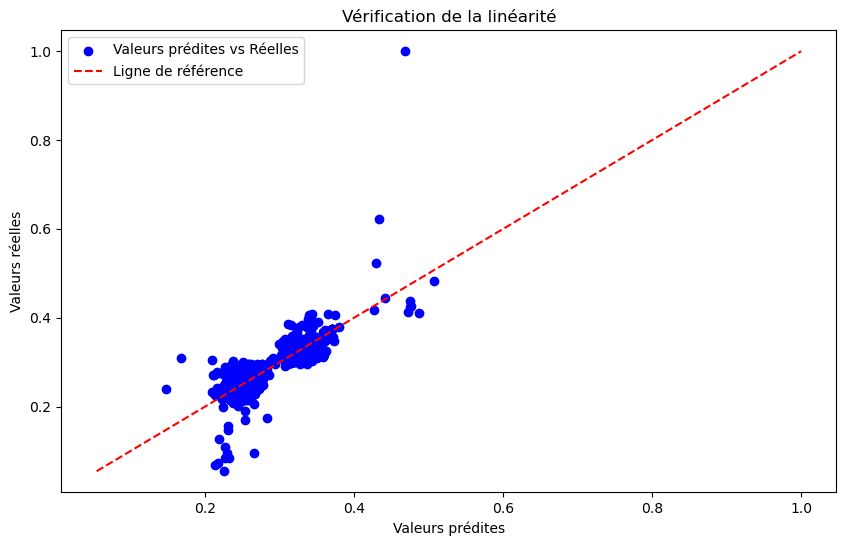

In [351]:
# Traçage des valeurs réelles vs. prédites
plt.figure(figsize=(10,6))
plt.scatter(y_pred, y_test, color='blue', label="Valeurs prédites vs Réelles")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ligne de référence")
plt.title("Vérification de la linéarité")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.legend()
plt.show()


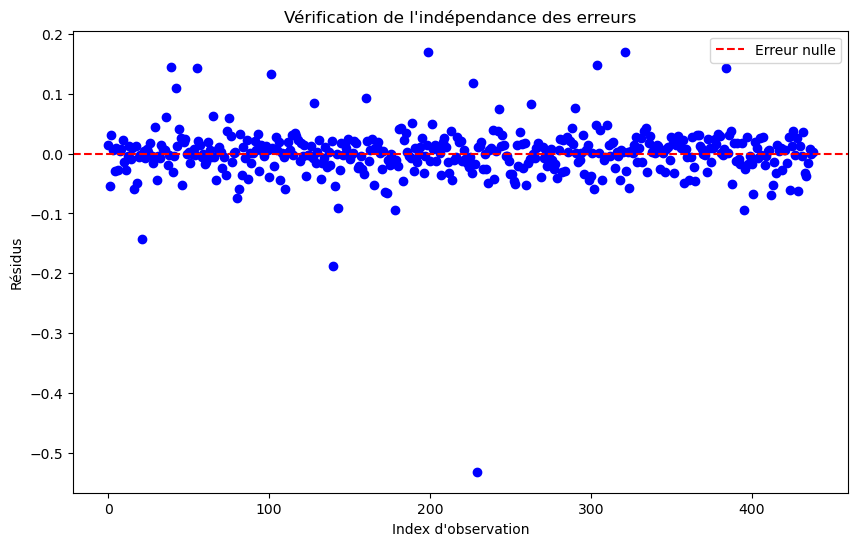

In [354]:
# Traçage des résidus vs index des observations
residuals=(y_pred - y_test)
plt.figure(figsize=(10,6))
plt.scatter(np.arange(len(residuals)), residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Erreur nulle')
plt.title("Vérification de l'indépendance des erreurs")
plt.xlabel("Index d'observation")
plt.ylabel("Résidus")
plt.legend()
plt.show()


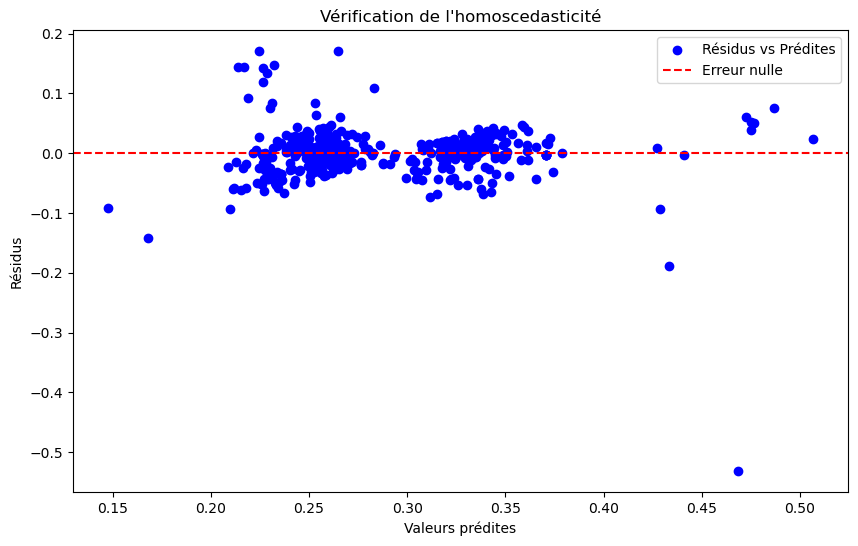

In [355]:
# Traçage des résidus vs valeurs prédites
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals, color='blue', label='Résidus vs Prédites')
plt.axhline(0, color='red', linestyle='--', label="Erreur nulle")
plt.title("Vérification de l'homoscedasticité")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.legend()
plt.show()


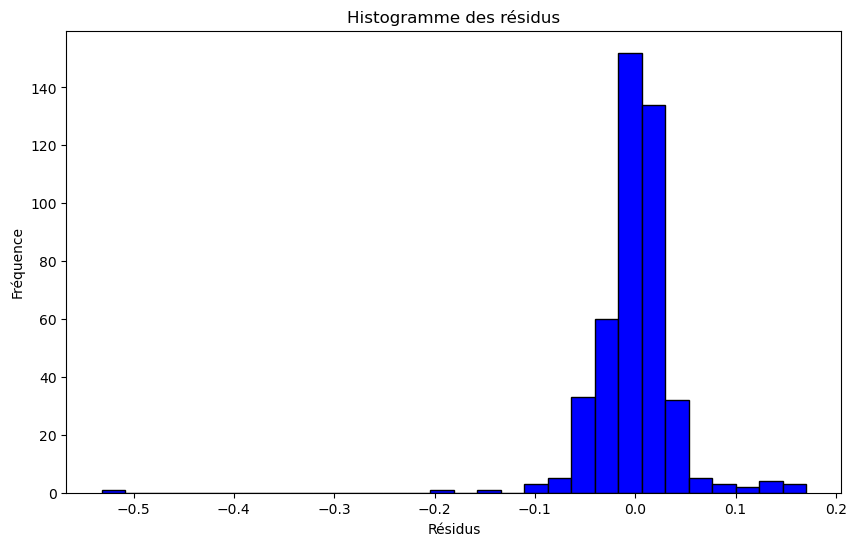

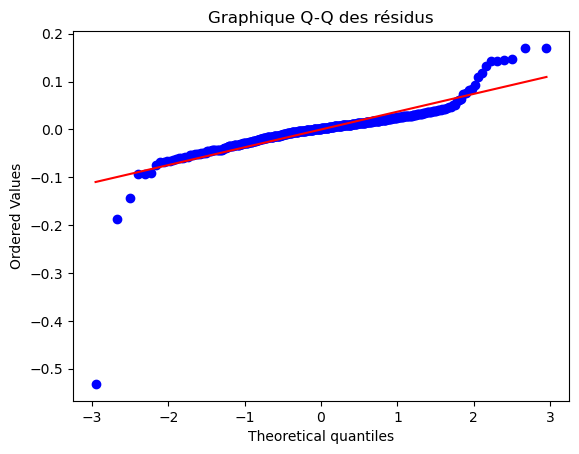

In [ ]:
# Histogramme des résidus
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black')
plt.title("Histogramme des résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.show()

# Graphique Q-Q des résidus
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Graphique Q-Q des résidus")
plt.show()


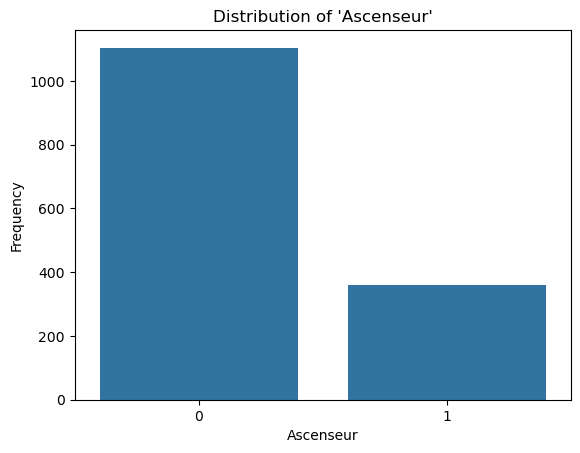

In [335]:
#Ploting distribution of Ascenseur 
sns.barplot(x=data_model['Ascenseur'].value_counts().index,
            y=data_model['Ascenseur'].value_counts().values)
plt.title("Distribution of 'Ascenseur'")
plt.xlabel("Ascenseur")
plt.ylabel("Frequency")
plt.show()


In [336]:
### equilbre ascenseur data 
x_data=data_model[['Price_boxcox_scale' , 'Chambre' , 'Salle de bain' ,'Salons' , 'Age de bien' , 'Etage'  , 'Surf_scale' , 'Cluster' ]]
y_data=data_model['Ascenseur']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_data, y_data)


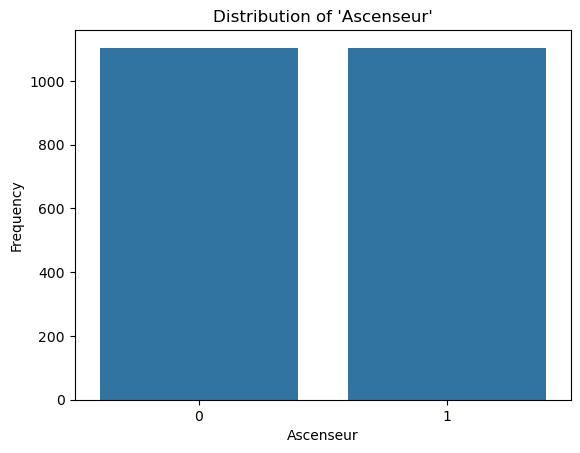

In [337]:
# Vérification la répartition des classes après SMOTE
sns.barplot(x=y_resampled.value_counts().index,
            y=y_resampled.value_counts().values)
plt.title("Distribution of 'Ascenseur'")
plt.xlabel("Ascenseur")
plt.ylabel("Frequency")
plt.show()

In [338]:
### spliting data into train , test 
x_train , x_test , y_train , y_test = train_test_split(X_resampled , y_resampled , test_size=0.3 , random_state=42)


In [339]:
### train LogisticRegression model 

model_lr=LogisticRegression()
model_lr.fit(x_train , y_train)
y_pred=model_lr.predict(x_test)

from sklearn.metrics import confusion_matrix , classification_report
print(confusion_matrix(y_pred , y_test))

print(classification_report(y_pred , y_test))


[[213 121]
 [127 202]]
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       334
           1       0.63      0.61      0.62       329

    accuracy                           0.63       663
   macro avg       0.63      0.63      0.63       663
weighted avg       0.63      0.63      0.63       663



In [340]:
### using gridsearch for detect best parametre  
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_params_)


{'max_depth': 20, 'n_estimators': 100}


In [ ]:
### using RandomForestClassifier model 
rf_best = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
rf_best.fit(x_train, y_train)
y_pred=rf_best.predict(x_test)

print(confusion_matrix(y_pred , y_test))


print(classification_report(y_pred , y_test))

[[272  63]
 [ 68 260]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       335
           1       0.80      0.79      0.80       328

    accuracy                           0.80       663
   macro avg       0.80      0.80      0.80       663
weighted avg       0.80      0.80      0.80       663



In [342]:
#testing parametre 
param_grid = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]  
}


grid = GridSearchCV(XGBClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)

print("Meilleurs paramètres XGBoost:", grid.best_params_)


xgb_best = grid.best_estimator_

# prediction and evaluation 
y_pred_xgb = xgb_best.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb))

Meilleurs paramètres XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       340
           1       0.79      0.79      0.79       323

    accuracy                           0.79       663
   macro avg       0.79      0.79      0.79       663
weighted avg       0.79      0.79      0.79       663



In [343]:
#testing parametre 

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 5, 10] 
}

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)

print("Meilleurs paramètres Gradient Boosting:", grid.best_params_)

gb_best = grid.best_estimator_

y_pred_gb = gb_best.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_gb))


Meilleurs paramètres Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       340
           1       0.77      0.78      0.78       323

    accuracy                           0.78       663
   macro avg       0.78      0.78      0.78       663
weighted avg       0.78      0.78      0.78       663



In [ ]:
print('for regression best model is : Polynomail regression degree 2 ')
print(" RandomForestClassifier with paramter {'max_depth': None, 'n_estimators': 200} ")

for regression best model is : Polynomail regression degree 2 
for classification the best model is : GradientBoostingClassifier with Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
 and RandomForestClassifier with paramter {'max_depth': None, 'n_estimators': 200} 
